# Timeline
- 2017-10-05 - Started

# Goal
Get better data about persuasiveness by:
- asking pairwise comparisons, within-subject where possible
- asking an impersonal question


## Get the analysis data

In [24]:
import os
import json
import pandas as pd
import toolz


In [3]:
os.chdir(os.path.expanduser('/Users/kcarnold/code/suggestion/'))

In [7]:
%run -m suggestion.aggregate_analysis -- --batch persuade_0

Inserted but backspaced... 3mr4jp tail tail
Inserted but backspaced... 7qc24j mily mil
Inserted but backspaced... 7qc24j friendly friend
Inserted but backspaced... 7qc24j go g
Inserted but backspaced... wgfq8r staurants stauran
Inserted but backspaced... v7g5x5 ence ence
Inserted but backspaced... v7g5x5 f f
Inserted but backspaced... v7g5x5 sh sh
Inserted but backspaced... v7g5x5 cles cle
Inserted but backspaced... v7g5x5 fs f
________________________________________________________________________________
[Memory] Calling suggestion.analysis_util.get_log_analysis_raw...
get_log_analysis_raw(PosixPath('/Users/kcarnold/code/suggestion/logs/5p85g8.jsonl'), 1611657, git_rev='ab04f1a', analysis_files={ 'analysis': '#!/bin/bash\n'
              'cd "$(dirname ${BASH_SOURCE[0]})"\n'
              'NODE_ENV=development ./node_modules/babel-cli/bin/babel-node.js '
              '--presets env,react-app analyze.js\n',
  'analyze.js': "import {analyzeLog} from './src/Analyzer.js';\n"
          

Construct pairs within subjects.

In [27]:
pairs = []
for participant_id, trials in trial_level_data[trial_level_data.argue_pro].groupby('participant_id'):
    pairs.append(dict(
        meta=dict(participant_id=participant_id),
        texts=trials.filter('block,condition,final_text'.split(',')).to_dict('records')))
    
pairs    

[{'meta': {'participant_id': '3mr4jp'},
  'texts': [{'block': 1,
    'condition': 'sentneg',
    'final_text': "if i could give this place six stars i would. i love eating at this restaurant. they always have new specials and keep their classics as staples on the menu. they use local ingredients that are grown within a hundred mile radius of the restaurant. it's close to a lot of offices and is great for a working lunch or to take a client out for a good time. "},
   {'block': 2,
    'condition': 'sentpos',
    'final_text': 'i recently visited this restaurant for the first time for my birthday. everything about this place is amazing - the ambiance, coziness, food, service, cocktails - i could go on. it was a little pricier than most places in town, but the food is just great and the staff is always very friendly. i would definitely recommend this place for anyone looking for a good local flavor. '}]},
 {'meta': {'participant_id': '5p85g8'},
  'texts': [{'block': 0,
    'condition': 's

For attention checks, we need a set of phrases that are unique to each review. For each review, generate N such phrases.

In [129]:
import random
def rand_substring(s, num_words):
    words = s.split()
    start_idx = random.randrange(len(words) - num_words)
    return ' '.join(words[start_idx:start_idx + num_words])

num_words = 5
num_phrases_per_review = 5
singleton_texts = {}
for pair_idx, pair in enumerate(pairs):
    for i in range(num_phrases_per_review):
        for text_idx, text in enumerate(pair['texts']):
            true_text = text['final_text']
            while True:
                true = rand_substring(true_text, num_words)
                assert true in true_text
                if true in singleton_texts:
                    continue # Oops, try again.
                if all(
                    true not in text['final_text']
                    for other_pair_idx, pair in enumerate(pairs)
                    for other_text_idx, text in enumerate(pair['texts'])
                    if (pair_idx, text_idx) != (other_pair_idx, other_text_idx)):
                    
                    singleton_texts[true] = pair_idx, text_idx
                    break
        

In [54]:
assert len(check_texts) == len(pairs)
for idx, check_text in enumerate(check_texts):
    pairs[idx]['check_texts'] = dict(good=check_text, bad=check_texts[(idx + 6) % len(check_texts)])


Shuffle pairs.

In [126]:
random.shuffle(pairs)

Create batches of 6 pairs.

In [146]:
def batchify(items, batch_size):
    batches = list(toolz.partition_all(batch_size, items))
    if len(batches[-1]) != batch_size:
        print("Tacking on extra to the last batch.")
        batches[-1] = (batches[-1] + batches[0])[:batch_size]
    assert len(batches[-1]) == batch_size
    return batches

def tasks_to_csv(tasks, out_fname):
    pd.DataFrame(dict(task=[json.dumps(task) for task in tasks])).to_csv(out_fname, index=False)

batches = batchify(pairs, 6)

Tacking on extra to the last batch.


For each pair, add one of its texts and 3 texts from completely different batches.

In [147]:
for batch in batches:
    batch_texts = ' '.join(text['final_text'] for pair in batch for text in pair['texts'])
    for pair in batch:
        which = random.randrange(2)
        true_text = pair['texts'][which]['final_text']
        true_snippets = [text for text in singleton_texts if text in true_text]
        assert len(true_snippets) == num_phrases_per_review
        true_snippet = random.choice(true_snippets)
        false_snippets = random.sample([text for text in singleton_texts if text not in batch_texts], 3)
        check_texts = {'true': true_snippet}
        for fidx, false in enumerate(false_snippets):
            check_texts[f'false{fidx}'] = false
        pair['check_texts'] = check_texts

In [148]:
batches[0][0]

{'check_texts': {'false0': "you haven't been here before,",
  'false1': 'super friendly and the prices',
  'false2': 'place you will only visit',
  'true': 'restaurant for the first time'},
 'meta': {'participant_id': '3mr4jp'},
 'texts': [{'block': 1,
   'condition': 'sentneg',
   'final_text': "if i could give this place six stars i would. i love eating at this restaurant. they always have new specials and keep their classics as staples on the menu. they use local ingredients that are grown within a hundred mile radius of the restaurant. it's close to a lot of offices and is great for a working lunch or to take a client out for a good time. "},
  {'block': 2,
   'condition': 'sentpos',
   'final_text': 'i recently visited this restaurant for the first time for my birthday. everything about this place is amazing - the ambiance, coziness, food, service, cocktails - i could go on. it was a little pricier than most places in town, but the food is just great and the staff is always very f

In [150]:
tasks_to_csv(batches, '/Users/kcarnold/code/suggestion/annotation_ui/pairwise-persuasive-task.csv')

# Analyze the data

I posted this on MTurk, with the following prompt:
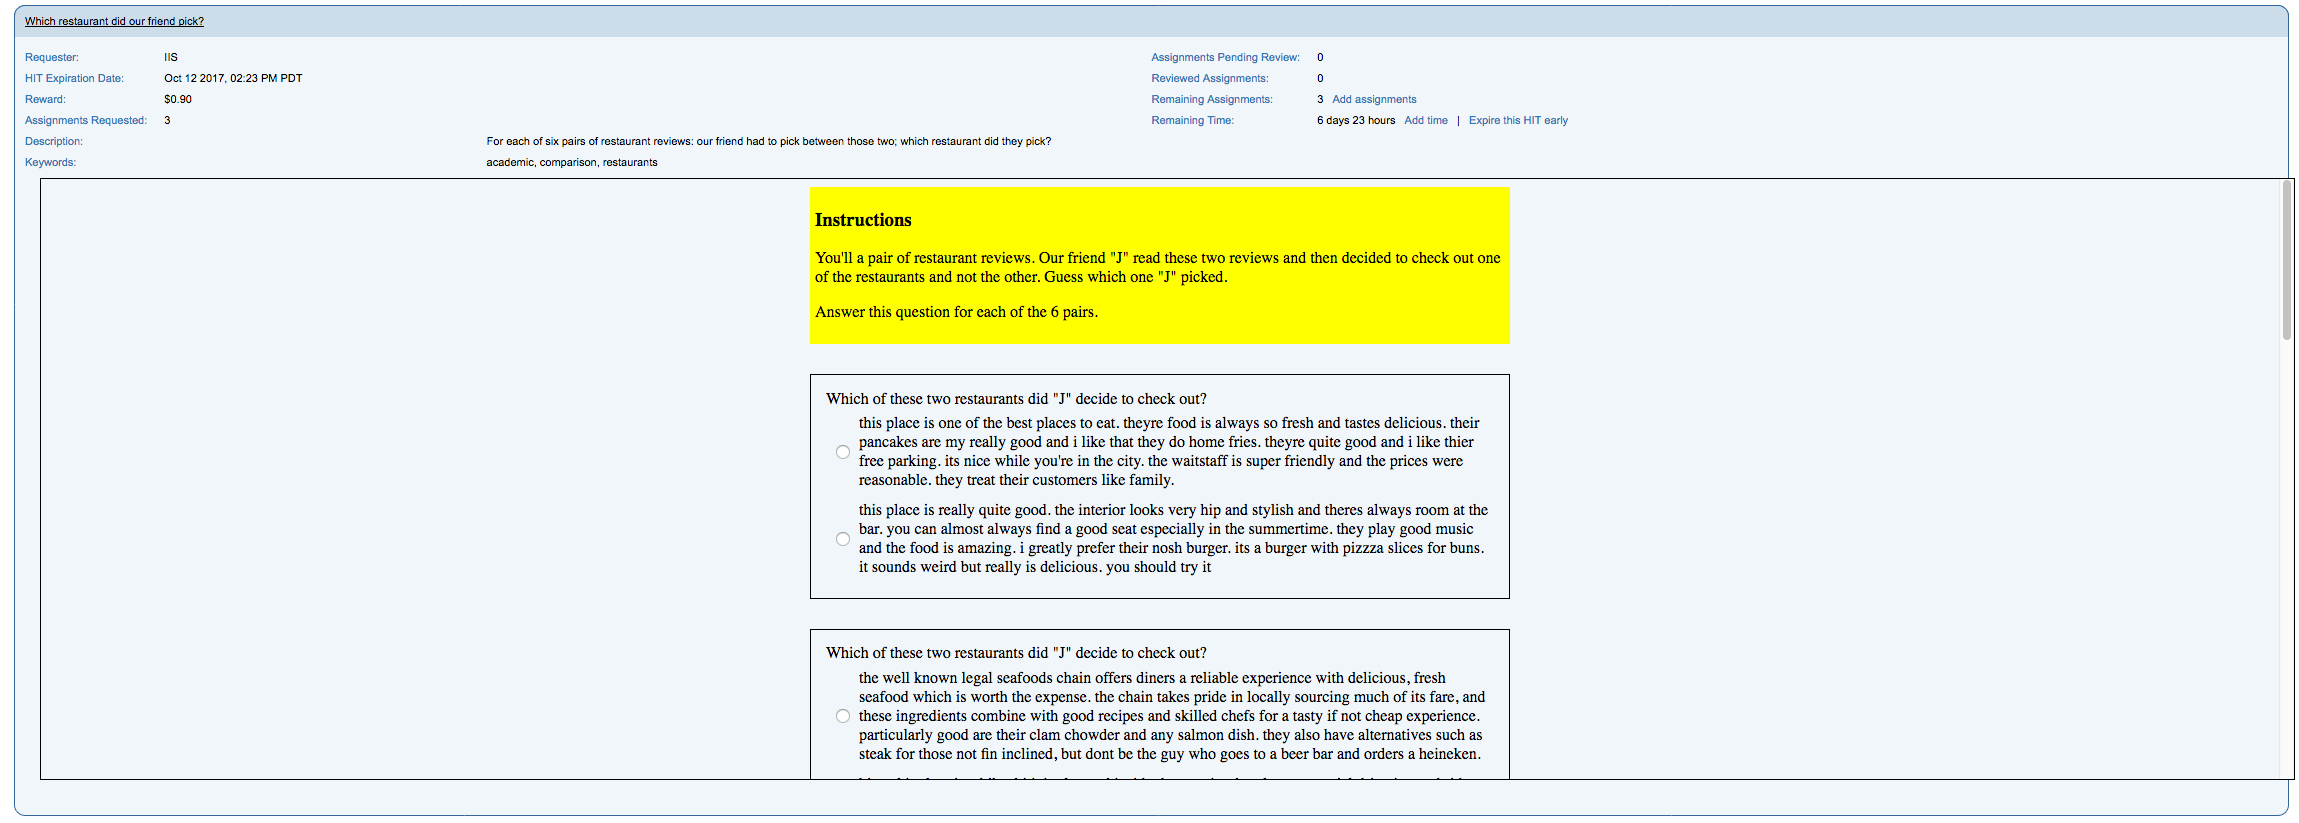

It includes an "attention check":
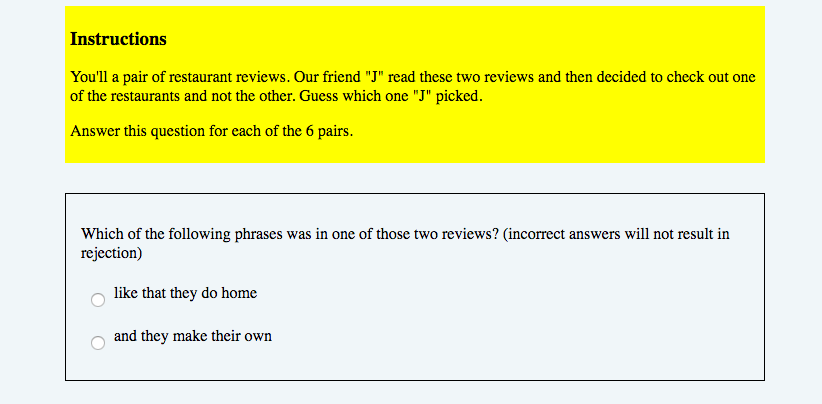

I downloaded the batch results and put them in ~/code/suggestion/gruntwork/turk_pairwise_persuasiveness/

In [72]:
from suggestion.paths import paths
result_files = list(paths.parent.joinpath('gruntwork', 'turk_pairwise_persuasiveness').glob('Batch*results.csv'))

raw = pd.concat([pd.read_csv(str(f)) for f in result_files], axis=0, ignore_index=True)
res = []
for record in raw.loc[:, ['WorkerId', 'Answer.results']].to_dict('records'):
    worker_id = record['WorkerId']
    for entry in json.loads(record['Answer.results']):
        res.append(dict(worker_id=worker_id, **entry.pop('meta'), **entry))
res = pd.DataFrame(res)


In [73]:
res.groupby('worker_id').check_selected.value_counts()

worker_id       check_selected
A1U7O93JY3WFMU  good              6
A1VZSFHTU51JP0  good              6
A2NA2OJT15COZY  good              6
A2XJH3WC02RMXQ  good              5
                bad               1
AA4KKLIU4C3NY   good              4
                bad               2
AKLV0WIZZ356X   good              4
                bad               2
AKSJ3C5O3V9RB   good              9
                bad               3
AUOLR6JOD7STS   good              6
Name: check_selected, dtype: int64

Eyeballing, it looks like people generally paid attention. But that test doesn't give much statistical power, since random guessing does pretty well. **Next time I need to include more alternatives!**

In [66]:
from scipy.stats import binom_test
binom_test([5,1])

0.21875000000000003

But under the assumption that everyone did reasonably, what do we get?

In [74]:
res.groupby('participant_id').selected.value_counts()

participant_id  selected
3mr4jp          0           3
                1           3
5p85g8          1           2
                0           1
73cqx8          1           3
75x3vv          0           2
                1           1
7qc24j          1           2
                0           1
8g355x          1           2
                0           1
g254c9          1           2
                0           1
g6f9gj          0           2
                1           1
gq95xx          0           2
                1           1
h822fr          1           3
mw9943          0           2
                1           1
r3ghhw          0           2
                1           1
r5w3h9          0           2
                1           1
v7g5x5          0           2
                1           1
vcgh69          0           2
                1           1
wgfq8r          0           2
                1           1
x42fwx          1           2
                0           1
Name: selected,

Hm, that's not very good inter-annotator agreement. Did I mess up something?

In [77]:
res['left'] = (res.selected == 0) ^ res.swap 

In [80]:
res.groupby('participant_id').mean().mean()

pairIdx     2.500000
selected    0.519608
swap        0.549020
left        0.460784
dtype: float64

Hm. That's pretty bad -- only marginal more agreement than whether they picked the left side. But it's still slightly larger, so let's run with it for a minute..

In [81]:
res

,check_selected,check_texts,pairIdx,participant_id,selected,swap,texts,worker_id,left
0,good,"{'good': 'first time for my birthday.', 'bad':...",0,3mr4jp,0,True,"[{'idx': 1, 'block': 2, 'condition': 'sentpos'...",A2NA2OJT15COZY,False
1,good,"{'good': 'and they make their own', 'bad': 'th...",1,5p85g8,1,False,"[{'idx': 0, 'block': 0, 'condition': 'sentpos'...",A2NA2OJT15COZY,False
2,good,"{'good': 'to eat at bozo's. i', 'bad': 'i love...",2,73cqx8,1,True,"[{'idx': 1, 'block': 2, 'condition': 'sentpos'...",A2NA2OJT15COZY,True
3,good,"{'good': 'are mostly braised, steamed or', 'ba...",3,75x3vv,0,True,"[{'idx': 1, 'block': 2, 'condition': 'sentneg'...",A2NA2OJT15COZY,False
4,good,"{'good': 'complaint i have about this', 'bad':...",4,7qc24j,1,True,"[{'idx': 1, 'block': 1, 'condition': 'zerosugg...",A2NA2OJT15COZY,True
5,good,"{'good': 'i love this place so', 'bad': 'albei...",5,8g355x,1,True,"[{'idx': 1, 'block': 2, 'condition': 'zerosugg...",A2NA2OJT15COZY,True
6,bad,"{'good': 'first time for my birthday.', 'bad':...",0,3mr4jp,0,True,"[{'idx': 1, 'block': 2, 'condition': 'sentpos'...",AKSJ3C5O3V9RB,False
7,good,"{'good': 'and they make their own', 'bad': 'th...",1,5p85g8,1,True,"[{'idx': 1, 'block': 1, 'condition': 'sentneg'...",AKSJ3C5O3V9RB,True
8,good,"{'good': 'to eat at bozo's. i', 'bad': 'i love...",2,73cqx8,1,False,"[{'idx': 0, 'block': 1, 'condition': 'zerosugg...",AKSJ3C5O3V9RB,False
9,bad,"{'good': 'are mostly braised, steamed or', 'ba...",3,75x3vv,1,False,"[{'idx': 0, 'block': 0, 'condition': 'sentpos'...",AKSJ3C5O3V9RB,False


In [86]:
res2 = []
for row in res.itertuples():
    conditions = [text['condition'] for text in row.texts]
    selected_condition = conditions[row.selected]
    res2.append(dict(
        participant_id=row.participant_id,
        worker_id=row.worker_id,
        conditions=','.join(sorted(conditions)),
        selected_condition=selected_condition))
winners = pd.DataFrame(res2)
del res2

In [90]:
win_counts = winners.groupby(['participant_id', 'conditions']).selected_condition.value_counts().unstack()

In [100]:
win_counts

,selected_condition,sentneg,sentpos,zerosugg
participant_id,conditions,,,
3mr4jp,"sentneg,sentpos",3.0,3.0,NaN
5p85g8,"sentneg,sentpos",2.0,1.0,NaN
73cqx8,"sentpos,zerosugg",NaN,1.0,2.0
75x3vv,"sentneg,sentpos",2.0,1.0,NaN
7qc24j,"sentpos,zerosugg",NaN,2.0,1.0
8g355x,"sentpos,zerosugg",NaN,3.0,NaN
g254c9,"sentneg,zerosugg",NaN,NaN,3.0
g6f9gj,"sentneg,sentpos",1.0,2.0,NaN
gq95xx,"sentneg,sentpos",2.0,1.0,NaN


In [98]:
win_fracs = win_counts.div(win_counts.sum(axis=1), axis=0).reset_index()

In [122]:
for conditions, group in win_fracs.groupby('conditions'):
    print(conditions, len(group))
    group = group.fillna(0)
    # Note: need to fill NAs because otherwise the denominator of the means would be wrong.
    print('fracs:', group.mean().loc[conditions.split(',')].to_dict())
    print('hard wins:', (group > .5).sum().loc[conditions.split(',')].to_dict())

sentneg,sentpos 7
fracs: {'sentneg': 0.54761904761904756, 'sentpos': 0.45238095238095238}
hard wins: {'sentneg': 4, 'sentpos': 2}
sentneg,zerosugg 3
fracs: {'sentneg': 0.55555555555555547, 'zerosugg': 0.44444444444444442}
hard wins: {'sentneg': 2, 'zerosugg': 1}
sentpos,zerosugg 7
fracs: {'sentpos': 0.5714285714285714, 'zerosugg': 0.42857142857142855}
hard wins: {'sentpos': 4, 'zerosugg': 3}


Interestingly, both of the suggestion conditions won over zerosugg, and sentneg won by a little bit over sentpos. But counterbalancing went very wrong and I got 7 annotations for most pairs but only 3 for sentneg vs zerosugg. Is this just noise? If I took a strict binomial on the hard wins, there are 10 comparisons between a suggestion and a no-suggestion condition, of which a suggestion condition won in 6 of them. That's pretty weak:

In [124]:
binom_test([6,4])

0.75390625000000022

So we have weak evidence for `neg > pos > none`.